# Experiment with caltech101 using SIFT features

In [4]:
import os
from scipy.misc import imread
from sklearn.model_selection import train_test_split
from datetime import datetime
import pickle
import scipy.io
import numpy as np
from numpy import linalg as LA
import time
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.metrics import accuracy_score
import seaborn as sns


from train_test_split import split
from okl_fct import okl, lrokl, mse, predict

with open('sift_feature_withoutback/y_train_sift.dat', 'rb') as f:
    y_train = pickle.load(f)
with open('sift_feature_withoutback/y_test_sift.dat', 'rb') as f:
    y_test = pickle.load(f)
with open('sift_feature_withoutback/sift_feature_train500.dat', 'rb') as f:
    sift_train = pickle.load(f)
with open('sift_feature_withoutback/sift_feature_test500.dat', 'rb') as f:
    sift_test = pickle.load(f)

In [119]:
print('size train: %i'%len(sift_train))
print('size test: %i'%len(sift_test))

size train: 6957
size test: 1720


## calculate input kernel

In [6]:
K_train = rbf_kernel(sift_train)
K_test = rbf_kernel(sift_test,sift_train)

## train okl 

In [7]:
%%time
N = 30
lam_list = np.logspace(-5,0,N) * np.sqrt(LA.norm(np.dot(np.dot(y_train.T,K_train),y_train)))
lam_list = np.sort(lam_list)[::-1]

"""okl"""
model_sift = okl(K_train,y_train,lam_list)

lambda = 676.939431448
lambda = 455.130582818
lambda = 306.000563408
lambda = 205.735119416
lambda = 138.323076565
lambda = 92.9995499295
lambda = 62.5269224909
lambda = 42.0390855564
lambda = 28.2643802703
lambda = 19.0031534105
lambda = 12.77649947
lambda = 8.59009740014
lambda = 5.77542960945
lambda = 3.88302781912
lambda = 2.61069843521
lambda = 1.75526589999
lambda = 1.18012802173
lambda = 0.793442262891
lambda = 0.533459601799
lambda = 0.358663963417
lambda = 0.241142606151
lambda = 0.162128795844
lambda = 0.109004986142
lambda = 0.0732879495093
lambda = 0.0492741087668
lambda = 0.0331287450532
lambda = 0.0222736397728
lambda = 0.0149753643832
lambda = 0.0100684728987
lambda = 0.00676939431448
CPU times: user 6min, sys: 3min 49s, total: 9min 50s
Wall time: 1min 48s


In [8]:
pickle.dump(model_sift,open('model_sift.p','wb'))

## train for LROKL

In [89]:
%%time
"""lrokl"""
model2 = {}
p_list = np.array(range(200))+1
#p_list = np.array(range(100))+1
#p_list = np.array(range(100,120))+1
for it,p in enumerate(p_list):
    print('p = '+str(p))  
    modelp = lrokl(K_train,y_train,lam_list,p)
    model2[p] = modelp
    pickle.dump(model2,open('model2.p','wb'))

p = 101
p = 102
p = 103
p = 104
p = 105
p = 106
p = 107
p = 108
p = 109
p = 110
p = 111
p = 112
p = 113
p = 114
p = 115
p = 116
p = 117
p = 118
p = 119
p = 120
CPU times: user 2h 15min 20s, sys: 45min 39s, total: 3h 1min
Wall time: 51min 3s


In [83]:
model2 = pickle.load(open('model2.p','rb'))

### test for OKL

In [12]:
OKL_acc = np.zeros((N,1))
ex_time = np.zeros((N,1))
for k in range(N):
    ex_time[k] = model_sift[k]['time']
    pred_test_sift = predict(K_test,model_sift[k]['C'],model_sift[k]['L'])
    pred_test_clf_sift = np.zeros(pred_test_sift.shape)
    for j in range(len(pred_test_sift)):
        n = np.argmax(pred_test_sift[j])
        pred_test_clf_sift[j,n]=1        
    OKL_acc[k] = accuracy_score(y_test,pred_test_clf_sift)
    
jj = np.argmax(OKL_acc)
print('For OKL, when lambda = %.3f,\naccuracy score reaches the maximum = %.3f' %(lam_list[jj],OKL_acc[jj]))

For OKL, when lambda = 0.109,
accuracy score reaches the maximum = 0.454


In [122]:
pickle.dump(OKL_acc,open('result/OKL_acc.dat','wb'))
pickle.dump(ex_time,open('result/ex_time.dat','wb'))

### test for LROKL

In [73]:
p_list = list(model2.keys())
P = len(p_list)
LROKL_acc = np.zeros((P,N))
LRex_time = np.zeros((P,N))
for k in range(N):
    for t in p_list:
        #print(model2[t][k])
        LRex_time[t][k] = model2[t][k]['time']
        pred_test_sift = predict(K_test,model2[t][k]['A'],model2[t][k]['B'].T)
        pred_test_clf_sift = np.zeros(pred_test_sift.shape)
        for j in range(len(pred_test_sift)):
            n = np.argmax(pred_test_sift[j])
            pred_test_clf_sift[j,n]=1        
        LROKL_acc[t][k] = accuracy_score(y_test,pred_test_clf_sift)
    
kk,hh = np.unravel_index(LROKL_acc.argmax(), LROKL_acc.shape)
print('For low rank OKL, when p = %i, lambda = %.3f \naccuracy score reaches the maximum = %.3f' %(p_list[kk],lam_list[hh],LROKL_acc[kk][hh]))

For low rank OKL, when p = 100, lambda = 0.359 
accuracy score reaches the maximum = 0.453


In [120]:
pickle.dump(LROKL_acc,open('result/LROKL_acc.dat','wb'))
pickle.dump(LRex_time,open('result/LRex_time.dat','wb'))

# model selection

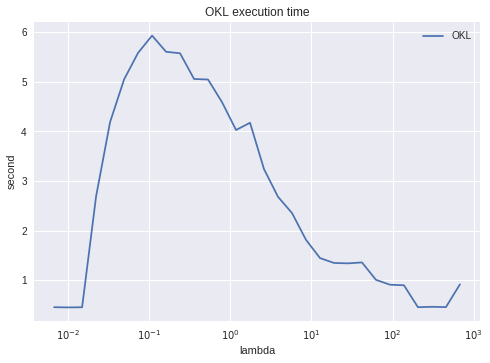

In [108]:
plt.semilogx(lam_list, ex_time,label='OKL')
plt.title('OKL execution time')
plt.grid(True)
plt.xlabel("lambda")
plt.ylabel("second")
plt.legend(loc=0)

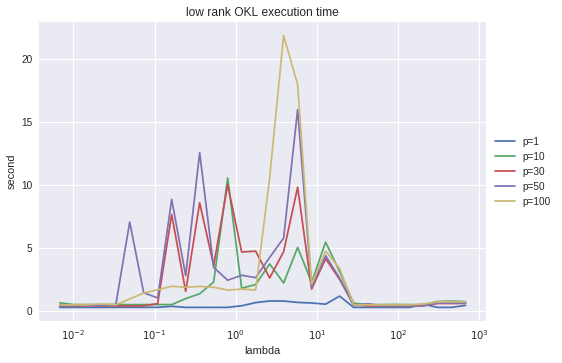

In [109]:
p_list_2=[1,10,30,50,100]
for i,p in enumerate(p_list_2):
    plt.semilogx(lam_list, LRex_time[p-1],label='p=%i'%p)
plt.title('low rank OKL execution time')
plt.grid(True)
plt.xlabel("lambda")
plt.ylabel("second")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

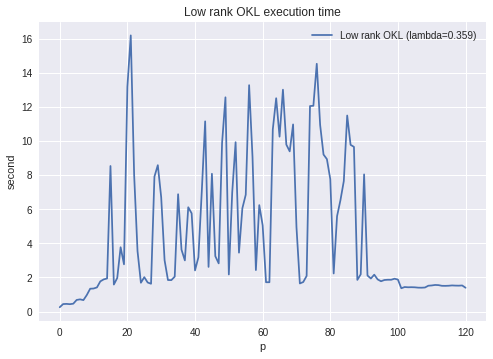

In [114]:
p_list = np.array(range(121))
plt.plot(p_list, LRex_time[:,hh],label='Low rank OKL (lambda=%.3f)'%lam_list[hh])
plt.title('Low rank OKL execution time')
plt.grid(True)
plt.xlabel("p")
plt.ylabel("second")
plt.legend(loc=0)

## plot test result

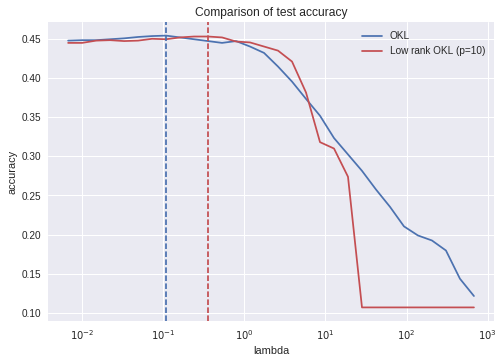

In [115]:
c=sns.color_palette()
plt.semilogx(lam_list, OKL_acc,label='OKL',color=c[0])
plt.semilogx(lam_list, LROKL_acc[kk],label='Low rank OKL (p=10)',color=c[2])
plt.axvline(x=lam_list[jj],color=c[0],linestyle='--')
plt.axvline(x=lam_list[hh],color=c[2],linestyle='--')
plt.title('Comparison of test accuracy')
plt.grid(True)
plt.xlabel("lambda")
plt.ylabel("accuracy")
plt.legend(loc=0)

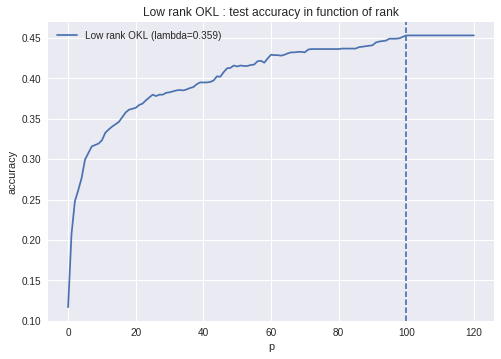

In [116]:
plt.plot(p_list, LROKL_acc[:,hh],label='Low rank OKL (lambda=%.3f)'%lam_list[hh],color=c[0])
plt.title('Low rank OKL : test accuracy in function of rank')
plt.axvline(x=p_list[kk],color=c[0],linestyle='--')
plt.grid(True)
plt.xlabel("p")
plt.ylabel("accuracy")
plt.legend(loc=0)